# 【第1回_Beginner限定コンペ】銀行の顧客ターゲティング

顧客の属性情報などから定期預金キャンペーンの反応率を予測しよう。

https://signate.jp/competitions/292

LightGBM編

## ライブラリインポート

In [701]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

import lightgbm as lgb
from optuna.integration import lightgbm as optuna_lgb
#import featuretools as ft

#from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split, KFold, StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score, roc_curve, auc

## データ読み込み・前処理

In [702]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

# poutcome の前処理済みファイルを使う
#train_df = pd.read_csv('y_train-Copy1.csv')
#test_df = pd.read_csv('y_test-Copy1.csv')
#train2_df = pd.read_csv('y_train-Copy2.csv')
#test2_df = pd.read_csv('y_test-Copy2.csv')
#train3_df = pd.read_csv('y_train-Copy3.csv')
#test3_df = pd.read_csv('y_test-Copy3.csv')

submit_df = pd.read_csv('submit_sample.csv', header=None)

In [703]:
print(train_df.shape)
print(test_df.shape)

(27100, 18)
(18050, 17)


In [704]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27100 entries, 0 to 27099
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   id         27100 non-null  int64 
 1   age        27100 non-null  int64 
 2   job        27100 non-null  object
 3   marital    27100 non-null  object
 4   education  27100 non-null  object
 5   default    27100 non-null  object
 6   balance    27100 non-null  int64 
 7   housing    27100 non-null  object
 8   loan       27100 non-null  object
 9   contact    27100 non-null  object
 10  day        27100 non-null  int64 
 11  month      27100 non-null  object
 12  duration   27100 non-null  int64 
 13  campaign   27100 non-null  int64 
 14  pdays      27100 non-null  int64 
 15  previous   27100 non-null  int64 
 16  poutcome   27100 non-null  object
 17  y          27100 non-null  int64 
dtypes: int64(9), object(9)
memory usage: 3.7+ MB


In [705]:
train_df['poutcome'].value_counts()

unknown    23099
failure     2717
other        826
success      458
Name: poutcome, dtype: int64

In [706]:
train_df['y'].value_counts()

0    24988
1     2112
Name: y, dtype: int64

In [707]:
train_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y
0,0,31,services,married,secondary,no,12294,yes,no,cellular,21,nov,101,3,498,0,other,0
1,1,29,entrepreneur,single,tertiary,no,43027,no,no,cellular,22,aug,158,2,702,0,unknown,1
2,2,35,management,married,tertiary,no,12252,yes,no,cellular,11,nov,351,1,826,0,failure,0
3,3,31,technician,married,secondary,no,99121,yes,yes,unknown,16,may,658,2,120,0,failure,0
4,4,48,unemployed,married,primary,no,42005,yes,no,telephone,3,apr,177,1,273,0,unknown,0


In [708]:
test_df.head()

,id,age,job,marital,education,default,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome
0,0,35,technician,single,secondary,no,89043,no,no,cellular,7,feb,101,2,184,2,success
1,1,37,services,married,secondary,no,64372,yes,no,cellular,7,jul,158,3,241,0,unknown
2,2,31,services,single,secondary,no,31606,yes,no,unknown,15,may,152,2,47,0,unknown
3,3,31,admin.,married,secondary,no,94826,yes,no,cellular,27,may,345,2,490,0,unknown
4,4,32,services,married,secondary,no,100401,no,no,cellular,7,jan,126,1,686,0,other


In [709]:
train_df.describe()

,id,age,balance,day,duration,campaign,pdays,previous,y
count,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000
mean,13549.500000,36.073284,47682.901771,16.700443,229.325387,1.775830,432.482399,0.085720,0.077934
std,7823.240484,7.816417,31650.760036,8.576252,204.939958,0.950045,252.150648,0.365889,0.268072
min,0.000000,22.000000,-6847.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000
25%,6774.750000,31.000000,20015.750000,8.000000,121.000000,1.000000,214.000000,0.000000,0.000000
50%,13549.500000,33.000000,47624.000000,17.000000,158.000000,1.000000,432.000000,0.000000,0.000000
75%,20324.250000,37.000000,75330.000000,26.000000,345.000000,2.000000,650.000000,0.000000,0.000000
max,27099.000000,90.000000,102121.000000,31.000000,3076.000000,5.000000,870.000000,3.000000,1.000000


In [710]:
test_df.describe()

,id,age,balance,day,duration,campaign,pdays,previous
count,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000
mean,9024.500000,36.104266,47158.451801,16.697950,229.315014,1.770083,436.171801,0.090859
std,5210.730515,7.863805,31469.525699,8.580203,208.796946,0.944872,251.392519,0.375801
min,0.000000,20.000000,-6838.000000,1.000000,0.000000,1.000000,-1.000000,0.000000
25%,4512.250000,31.000000,19654.500000,8.000000,121.000000,1.000000,219.250000,0.000000
50%,9024.500000,33.000000,46886.000000,17.000000,158.000000,1.000000,436.000000,0.000000
75%,13536.750000,37.000000,74178.000000,26.000000,345.000000,2.000000,654.000000,0.000000
max,18049.000000,90.000000,102124.000000,31.000000,3076.000000,4.000000,870.000000,3.000000


In [711]:
train_df.isnull().any()

id           False
age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
y            False
dtype: bool

In [712]:
test_df.isnull().any()

id           False
age          False
job          False
marital      False
education    False
default      False
balance      False
housing      False
loan         False
contact      False
day          False
month        False
duration     False
campaign     False
pdays        False
previous     False
poutcome     False
dtype: bool

In [713]:
# job のラベリングを y の平均の低い順にしてみる
#train_df.groupby('job').mean().sort_values('y')

データメモ

- testデータの `job` に `unknown` が一人いる (trainデータにはいない)

In [714]:
# one hot encoding
#train_df = pd.get_dummies(train_df, columns=['job', 'marital', 'education', 'contact', 'poutcome'])
#test_df = pd.get_dummies(test_df, columns=['job', 'marital', 'education', 'contact', 'poutcome'])
#test_df.drop(['job_unknown'], axis=1, inplace=True)

df_list = [train_df, test_df]

#train_df['poutcome'] = (train_df['poutcome'] + train2_df['poutcome'] + train3_df['poutcome']) / 3
#test_df['poutcome'] = (test_df['poutcome'] + test2_df['poutcome'] + test3_df['poutcome']) / 3

#job_encoder = LabelEncoder()
#job_encoder.fit(test_df['job'])

#job_label_mean = train_df.groupby('job')['y'].mean()

for df in df_list:
    #df['job'] = job_encoder.transform(df['job'])
    df['job'] = df['job'].map({'unknown': 1, 'technician': 2, 'blue-collar': 3, 'services': 4, 'entrepreneur': 5, 'admin.': 6, 'management': 7, 'housemaid': 8, 'self-employed': 9, 'unemployed': 10, 'retired': 11, 'student': 12})

    # Target Mean Encoding
    #df['target_job'] = df['job'].map(job_label_mean)
    #df.drop(['job'], axis=1, inplace=True)

    df['marital'] = df['marital'].map({'married': 2, 'divorced':1, 'single': 0})
    #df.drop(['marital'], axis=1, inplace=True)

    df['education'] = df['education'].map({'tertiary': 3, 'secondary': 2, 'primary': 1, 'unknown': 0})
    #df.drop(['education'], axis=1, inplace=True)

    #df['default'] = df['default'].map({'yes': 1, 'no': 0})
    df.drop(['default'], axis=1, inplace=True)

    df['housing'] = df['housing'].map({'yes': 1, 'no': 0})
    #df.drop(['housing'], axis=1, inplace=True)
    
    df['loan'] = df['loan'].map({'yes': 1, 'no': 0})
    #df.drop(['loan'], axis=1, inplace=True)

    df['contact'] = df['contact'].map({'telephone': 2, 'cellular': 1, 'unknown': 0})
    #df.drop(['contact'], axis=1, inplace=True)

    df['poutcome'] = df['poutcome'].map({'success': 3, 'unknown': 2, 'failure': 1, 'other': 0})
    
    df['month'] = df['month'].map({'jan': 1, 'feb': 2, 'mar': 3, 'apr': 4, 'may': 5, 'jun': 6, 'jul': 7, 'aug': 8, 'sep': 9, 'oct': 10, 'nov': 11, 'dec': 12})
    #df.drop(['day', 'month'], axis=1, inplace=True)
    
    # Feb 30 とかあって、正確には変換できない
    # → データの Feb 30 を Mar 1 に変換した(他にも、 2/31, 6/31, 11/31)
    df['days'] = pd.to_datetime('2016/' + df['month'].astype(str).str.pad(2,fillchar='0') + '/' + df['day'].astype(str).str.pad(2,fillchar='0'), format='%Y/%m/%d').dt.strftime('%j').astype('uint16')
    #df['days'] = df['month'] * 31 + df['day']
    
    #df['duration'] = np.log(df['duration'] + 1)
    df['bpp'] = np.log((df['balance'] - df['balance'].min()) / (df['pdays'] + 2) + 1)
    
    df.drop(['id'], axis=1, inplace=True)
    
# featuretools用
#y = train_df.pop('y')
#train_df['train'] = 1
#test_df['train'] = 0
#test_df['id'] = test_df['id'] + len(train_df)

In [715]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27100 entries, 0 to 27099
Data columns (total 18 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   age        27100 non-null  int64  
 1   job        27100 non-null  int64  
 2   marital    27100 non-null  int64  
 3   education  27100 non-null  int64  
 4   balance    27100 non-null  int64  
 5   housing    27100 non-null  int64  
 6   loan       27100 non-null  int64  
 7   contact    27100 non-null  int64  
 8   day        27100 non-null  int64  
 9   month      27100 non-null  int64  
 10  duration   27100 non-null  int64  
 11  campaign   27100 non-null  int64  
 12  pdays      27100 non-null  int64  
 13  previous   27100 non-null  int64  
 14  poutcome   27100 non-null  int64  
 15  y          27100 non-null  int64  
 16  days       27100 non-null  uint16 
 17  bpp        27100 non-null  float64
dtypes: float64(1), int64(16), uint16(1)
memory usage: 3.6 MB


In [716]:
train_df.head()

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,days,bpp
0,31,4,2,2,12294,1,0,1,21,11,101,3,498,0,0,0,326,3.670766
1,29,5,0,3,43027,0,0,1,22,8,158,2,702,0,2,1,235,4.274494
2,35,7,2,3,12252,1,0,1,11,11,351,1,826,0,1,0,316,3.180818
3,31,2,2,2,99121,1,1,0,16,5,658,2,120,0,1,0,137,6.768022
4,48,10,2,1,42005,1,0,2,3,4,177,1,273,0,2,0,94,5.185393


In [717]:
test_df.head()

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,days,bpp
0,35,2,0,2,89043,0,0,1,7,2,101,2,184,2,3,38,6.247054
1,37,4,2,2,64372,1,0,1,7,7,158,3,241,0,2,189,5.683734
2,31,4,0,2,31606,1,0,0,15,5,152,2,47,0,2,136,6.666411
3,31,6,2,2,94826,1,0,1,27,5,345,2,490,0,2,148,5.335778
4,32,4,2,2,100401,0,0,1,7,1,126,1,686,0,0,7,5.055422


In [718]:
train_df.describe()

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,y,days,bpp
count,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000,27100.000000
mean,36.073284,5.152509,1.386162,2.046125,47682.901771,0.583727,0.127269,0.788007,16.700443,6.003542,229.325387,1.775830,432.482399,0.085720,1.855683,0.077934,168.623579,4.852842
std,7.816417,2.669990,0.872384,0.727044,31650.760036,0.492949,0.333281,0.498535,8.576252,2.135158,204.939958,0.950045,252.150648,0.365889,0.467181,0.268072,65.155774,1.354737
min,22.000000,2.000000,0.000000,0.000000,-6847.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,0.000000,3.000000,0.000000
25%,31.000000,3.000000,0.000000,2.000000,20015.750000,0.000000,0.000000,0.000000,8.000000,5.000000,121.000000,1.000000,214.000000,0.000000,2.000000,0.000000,136.000000,4.148045
50%,33.000000,5.000000,2.000000,2.000000,47624.000000,1.000000,0.000000,1.000000,17.000000,5.000000,158.000000,1.000000,432.000000,0.000000,2.000000,0.000000,148.000000,4.842243
75%,37.000000,7.000000,2.000000,2.000000,75330.000000,1.000000,0.000000,1.000000,26.000000,7.000000,345.000000,2.000000,650.000000,0.000000,2.000000,0.000000,199.000000,5.530534
max,90.000000,12.000000,2.000000,3.000000,102121.000000,1.000000,1.000000,2.000000,31.000000,12.000000,3076.000000,5.000000,870.000000,3.000000,3.000000,1.000000,336.000000,11.571996


In [719]:
test_df.describe()

,age,job,marital,education,balance,housing,loan,contact,day,month,duration,campaign,pdays,previous,poutcome,days,bpp
count,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000,18050.000000
mean,36.104266,5.120388,1.382161,2.039501,47158.451801,0.577175,0.128587,0.783989,16.697950,5.998726,229.315014,1.770083,436.171801,0.090859,1.858061,168.471468,4.830517
std,7.863805,2.650421,0.873514,0.717774,31469.525699,0.494022,0.334752,0.504881,8.580203,2.118452,208.796946,0.944872,251.392519,0.375801,0.464028,64.614438,1.359378
min,20.000000,1.000000,0.000000,0.000000,-6838.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,1.000000,-1.000000,0.000000,0.000000,3.000000,0.000000
25%,31.000000,3.000000,0.000000,2.000000,19654.500000,0.000000,0.000000,0.000000,8.000000,5.000000,121.000000,1.000000,219.250000,0.000000,2.000000,136.000000,4.115297
50%,33.000000,5.000000,2.000000,2.000000,46886.000000,1.000000,0.000000,1.000000,17.000000,5.000000,158.000000,1.000000,436.000000,0.000000,2.000000,148.000000,4.818492
75%,37.000000,7.000000,2.000000,2.000000,74178.000000,1.000000,0.000000,1.000000,26.000000,7.000000,345.000000,2.000000,654.000000,0.000000,2.000000,199.000000,5.512622
max,90.000000,12.000000,2.000000,3.000000,102124.000000,1.000000,1.000000,2.000000,31.000000,12.000000,3076.000000,4.000000,870.000000,3.000000,3.000000,336.000000,11.597248


In [720]:
# featuretools による総当り特徴量生成

#df = pd.concat([train_df, test_df])

#es = ft.EntitySet(id='bank')
#es.entity_from_dataframe(entity_id='bank', dataframe=df, index='id')
#feature_matrix, feature_defs = ft.dfs(
#    entityset=es,
#    target_entity='bank',
#    trans_primitives=['subtract_numeric'],
#    agg_primitives=[],
#    max_depth=1,
#)

#df_dict = {}
#for name, group in feature_matrix.groupby('train'):
#    df_dict[name] = group
    
#train_df = df_dict[1]
#test_df = df_dict[0]

#train_df.drop(['train'], axis=1, inplace=True)
#test_df.drop(['train'], axis=1, inplace=True)


In [721]:
#train_df.head()

In [722]:
#test_df.head()

In [723]:
#train_df.info()

In [724]:
#train_pg = sns.pairplot(train_df.drop(['month', 'day'], axis=1), hue='y')
#train_pg = sns.pairplot(train_df, hue='y')
#train_pg.savefig('train_df.png')

#test_pg = sns.pairplot(test_df)
#test_pg.savefig('test_df.png')

## 学習準備

In [725]:
y = train_df.pop('y')

#X_train, X_test, y_train, y_test = train_test_split(train_df, y, test_size=0.2, random_state=44)
#X_train, X_test, y_train, y_test = train_test_split(train_df, y, random_state=44)

#train_data = lgb.Dataset(data=X_train, label=y_train, free_raw_data=False)
#test_data = lgb.Dataset(data=X_test, label=y_test, free_raw_data=False)
final_train_set = lgb.Dataset(data=train_df, label=y, free_raw_data=False)

folds = StratifiedKFold(n_splits=3, shuffle=True, random_state=33)

## ハイパーパラメータ

In [726]:
lgb_params = {
    #'boosting': 'dart',          # dart (drop out trees) often performs better
    'objective': 'binary',     # Binary classification
    'metric': 'auc',  # Area under ROC curve as the evaulation metric
    # 以下はoptunaでチューニングする
    #'learning_rate': 0.05,       # Learning rate, controls size of a gradient descent step
    #'min_data_in_leaf': 20,      # Data set is quite small so reduce this a bit
    #'feature_fraction': 0.7,     # Proportion of features in each boost, controls overfitting
    #'num_leaves': 41,            # Controls size of tree since LGBM uses leaf wise splits
    #'drop_rate': 0.15
}

## 学習

In [727]:
tuner = optuna_lgb.LightGBMTunerCV(
    lgb_params,
    final_train_set,
    num_boost_round=1000,
    #early_stopping_rounds=100,
    verbose_eval=0,
    #early_stopping_rounds=100,
    folds=folds
)
tuner.run()

print("  Params: ")
for key, value in tuner.best_params.items():
    print("    {}: {}".format(key, value))

min_data_in_leaf, val_score: 0.854366: 100%|##########| 5/5 [00:11<00:00,  2.38s/it]


  Params: 
    objective: binary
    metric: auc
    lambda_l1: 8.833318118443586
    lambda_l2: 5.36182957531961e-07
    num_leaves: 5
    feature_fraction: 0.4
    bagging_fraction: 0.9764960490882801
    bagging_freq: 7
    min_child_samples: 20


In [728]:
evaluation_results = {}

clf = lgb.train(
    train_set=train_data,
    params=tuner.best_params,
    valid_sets=[train_data, test_data], 
    valid_names=['Train', 'Test'],
    evals_result=evaluation_results,
    num_boost_round=1000,
    early_stopping_rounds=100,
    verbose_eval=100
)
optimum_boost_rounds = clf.best_iteration

print('Result:')
print(clf.params)
print(clf.best_score)

Training until validation scores don't improve for 100 rounds
[100]	Train's auc: 0.856433	Test's auc: 0.836187
[200]	Train's auc: 0.86875	Test's auc: 0.843943
[300]	Train's auc: 0.875889	Test's auc: 0.846841
[400]	Train's auc: 0.881276	Test's auc: 0.847717
[500]	Train's auc: 0.885354	Test's auc: 0.847774
[600]	Train's auc: 0.888376	Test's auc: 0.848017
Early stopping, best iteration is:
[517]	Train's auc: 0.885922	Test's auc: 0.848121
Result:
{'objective': 'binary', 'metric': 'auc', 'lambda_l1': 8.833318118443586, 'lambda_l2': 5.36182957531961e-07, 'num_leaves': 5, 'feature_fraction': 0.4, 'bagging_fraction': 0.9764960490882801, 'bagging_freq': 7, 'min_child_samples': 20}
defaultdict(<class 'collections.OrderedDict'>, {'Train': OrderedDict([('auc', 0.8859224115634372)]), 'Test': OrderedDict([('auc', 0.8481208949984034)])})


## 可視化

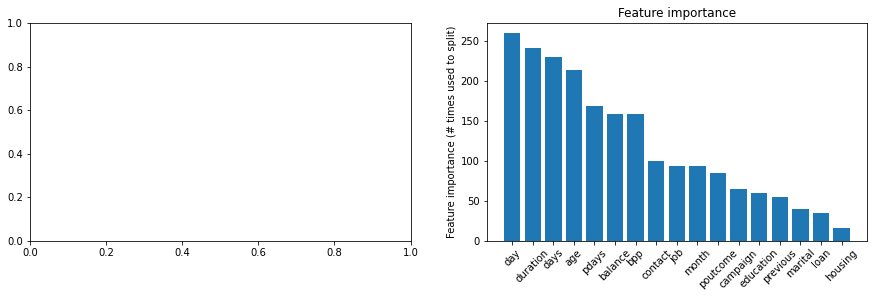

In [729]:
fig, axs = plt.subplots(1, 2, figsize=[15, 4])

# Plot the log loss during training
#axs[0].plot(evaluation_results['Train']['binary_logloss'], label='Train')
#axs[0].plot(evaluation_results['Test']['binary_logloss'], label='Test')
#axs[0].set_ylabel('Log loss')
#axs[0].set_xlabel('Boosting round')
#axs[0].set_title('Training performance')
#axs[0].legend()

# Plot feature importance
importances = pd.DataFrame({'features': clf.feature_name(), 
                            'importance': clf.feature_importance()}).sort_values('importance', ascending=False)
axs[1].bar(x=np.arange(len(importances)), height=importances['importance'])
axs[1].set_xticks(np.arange(len(importances)))
axs[1].set_xticklabels(importances['features'], rotation = 45)
axs[1].set_ylabel('Feature importance (# times used to split)')
axs[1].set_title('Feature importance')

plt.show()

In [730]:
importances.sort_values('importance')

,features,importance
5,housing,16
6,loan,35
2,marital,39
13,previous,55
3,education,60
11,campaign,64
14,poutcome,85
9,month,93
1,job,93
7,contact,100


In [731]:
preds = np.round(clf.predict(X_test))
print('Accuracy score = \t {}'.format(accuracy_score(y_test, preds)))
print('Precision score = \t {}'.format(precision_score(y_test, preds)))
print('Recall score =   \t {}'.format(recall_score(y_test, preds)))
print('F1 score =      \t {}'.format(f1_score(y_test, preds)))

Accuracy score = 	 0.9323985239852398
Precision score = 	 0.8055555555555556
Recall score =   	 0.21245421245421245
F1 score =      	 0.33623188405797105


In [732]:
fpr, tpr, thresholds = roc_curve(y_test, preds)
auc = auc(fpr, tpr)
print(auc)

0.6039795544531457


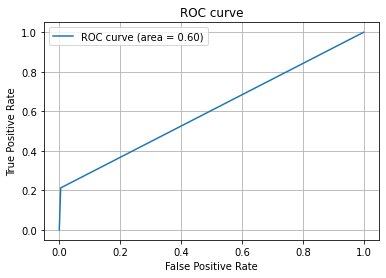

In [733]:
# ROC曲線をプロット
plt.plot(fpr, tpr, label='ROC curve (area = %.2f)'%auc)
plt.legend()
plt.title('ROC curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.grid(True)

## 推論

In [734]:
test_pred = clf.predict(test_df, num_iteration=optimum_boost_rounds)

In [735]:
submit_df[1] = test_pred
submit_df.to_csv('submit-lg.csv', header=False, index=False)

In [736]:
#pseudo labeling

#test_df['y'] = test_pred
#test_df.to_csv('test_p1.csv', index=False)